# Подготовка датасета, подготовка видео и обучение нейросети

# Предварительно была выполнена аналитика датасета и выделено несколько ключевых закономерностей/инсайтов о датасете:

1. Минимальная длина заставки к видео 5-10 секунд и на протяжении всего этого времени - каждый кадр в видео является заставкой.
2. Кадры заставки идут подряд, кадры не заставки тоже идут подряд
3. Всего в датасете 2 возможных значения fps - 24 или 25.
4. Два видео с длиной заставки в ~60 и ~80 секунд будут являться выбросами.
5. Минимальная ширина видео - 480 пикселей, а минимальная высота - 360 пикселей, то есть размер видео можно унифицировать сжатием до меньших значений (downscaling).
6. Зависимости времени заставки от времени начала заставки или времени окончания заставки выделить не удалось, поэтому потребуется более хитрый алгоритм.

# Моя стратегия работы по обучению нейросети:

1. Универсального подхода по работе с видео на данный момент не существует, большинство доступных решений (kaggle, hugging face) - это работа с изображениями или работа с видео но покадрово, то необходимо придумать свой способ реализации задачи поиска времени начала и окончания заставки.
2. Видео в общем смысле состоит из 3х составляющих - кадры, временное распределение кадров, звук. Для полноценного решения задачи определения времени заставки необходимо использовать все 3 данных параметра.
3. Из рассмотренных вариантов, изученных открытых решений и опыта решения задач связанных с видео можно рассмотреть несколько подходов:
- Первый вариант - рассмотреть видео - как 3д матрицу, в общем случае 4д матрицу (терзор) - 1 ось - цветовые каналы, 2 оси ширина и высота кадра, 1 ось - набор кадров. Тогда после использовании 4д свертки можно получить 3х мерное изображение, с которым уже можно работать далее при помощи нейросети, но есть несколько ограничений: сложность написания такой сети в короткие сроки и малый размер датасета - всего 125 (123 после удаления выбросов) видео, по такому количеству элементов для обучения сложно получить хороший результат
-  Второй вариант (основа моей стратегии) - это разметить датасет покадрово на 2 класса - кадр заставки/кадр не заставки и решать задачу бинарной классификации кадров. Так как подходящих кадров в каждом видео будет в среднем mean(время заставки) * mean(fps) * 85 = 26.5 тыс кадров заставок + столько же кадров не заставок добавить, в итоге получится 53 тыс картинок (кадров) если сбалансировать классы, или даже более если сделать классы несбалансироваными, что является достаточным для обучения нейросети датасетом. Использовать я планирую нейросеть YOLOv11cls, предобученной версии, поэтому на выходе можно получать вероятность принадлежности кадра к заставке. После того, как такая нейросеть пройдется по всем кадрам видео будет участок видео, где кадры идущие подряд принадлежат классу заставка, значит заставка будет идти именно в этом месте. Следовательно можно получить конкретный номер кадра - когда начинается и заканчивается заставка, а значит и конкретные временные метки.
-  Третий подход - это файнтюнинг второго подхода и мультимодальная стратегия - например вместо одного из цветового канала картинки можно вставить фильтр Cобеля, так как в заставке присутствует контрастный текст, что позволит модели выделять такие кадры и к получившемуся результату добавить вторую нейросеть, которая будет анализировать только звуковой канал и выдавать метки времени начала и конца заставки исходя из звука, потом после усреднения результата звуковой модели и модели картиночной (с некоторыми весовыми коэффициентами) можно будет получить результат.

4. Базово мною будет выполнен второй вариант, в дальнейшем к нему можно будет добавить 3й вариант.

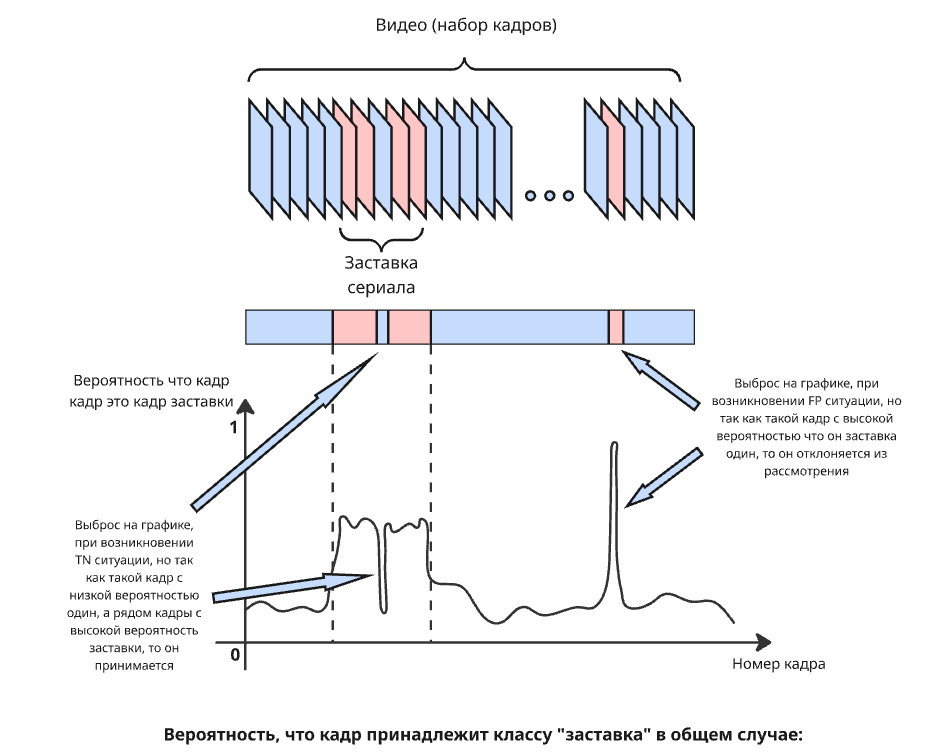
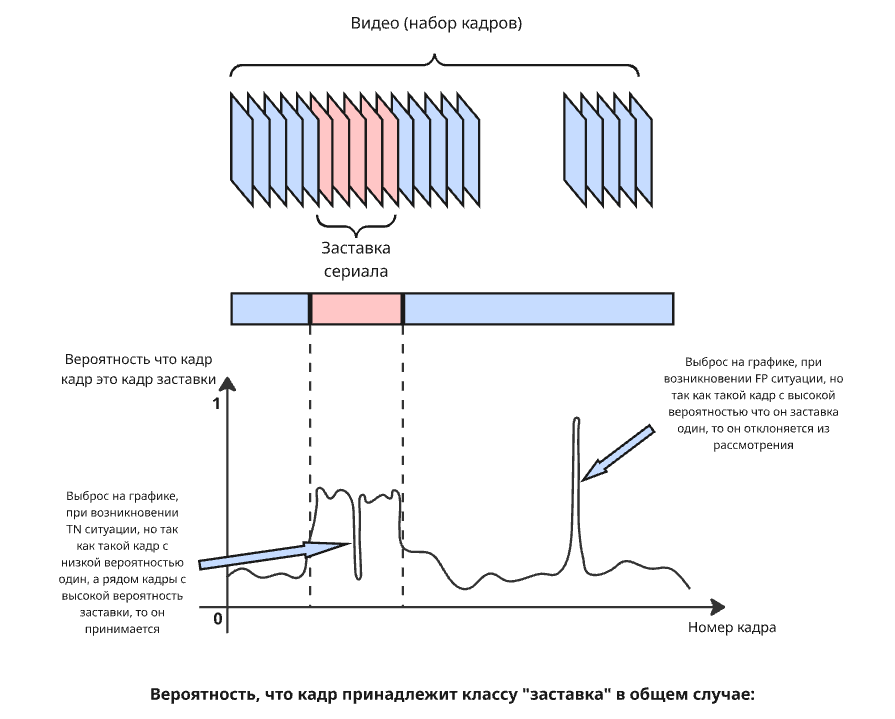

# Ниже представлен пайплайн исследования и обучения модели нейронной сети для решения задачи бинарной классификации кадров из видео на 2 класса - заставка/не заставка

In [1]:
!python -m pip install -U ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 19.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00:00:01m00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 5.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 76.9 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.9.41
    Uninstalling nvidia-nvjitlink-cu12-12.9.41:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.9.41
  Attempting uninstall: nvidia-curand-cu12
    Found exi

In [2]:
# импорт необходимых библиотек
import numpy as np
import pandas as pd
import os
import json
from datetime import datetime, timedelta
import cv2
import random
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


# Подготовим и разметим датасет

1) Спарсим информацию о видео из json, правильно данную информацию обработаем (как это делали в аналитике) и создадим единый словарь с информацией {id video: [время начала заставки, время окончания заставки]}

In [3]:
project_dir = '/kaggle/input/vk-series-data/'
test_target = os.path.join(project_dir, 'test_labels.json')
train_target = os.path.join(project_dir, 'train_labels.json')

with open(test_target) as f:
    test_target_dict = json.load(f)

with open(train_target) as f:
    train_target_dict = json.load(f)

np_labels = {}

def process_bad_times(dictionary):

    for name, description in dictionary.items():
        start_time = datetime.strptime(description["start"], "%H:%M:%S")
        end_time = datetime.strptime(description["end"], "%H:%M:%S")
        if start_time > end_time:
            start_time = start_time - timedelta(minutes=1)
            description["start"] = start_time.strftime("%H:%M:%S")

        np_labels[name] = [description["start"], description["end"]]

process_bad_times(train_target_dict)
process_bad_times(test_target_dict)

# Не было вычислено при анализе из-за метода записи и конкатенации датафреймов, и определилось только сейчас, но у нас всего 110 уникальных записей (уникальных видео), записи меток у таких видео идентичны, следовательно разделение test/val/train будет выполнено в соотношении 10/15/85.

2. Всю выборку - 110 видео разделим на test/val/train в соотношении 10/15/85. Обработаем видео и получим готовые dataloaders со сбалансированными классами заставка/не заставка - 1/0 

In [4]:
# Соберу пути до всех файлов в один массив

project_dir = '/kaggle/input/vk-series-data/'
test_path = os.path.join(project_dir, 'data_test_short/data_test_short/')
train_path = os.path.join(project_dir, 'data_train_short/data_train_short/')

paths = []

def scan_paths(root_paths):
    seen = set()
    paths = []
    for root in root_paths:
        for entry in os.scandir(root):
            if entry.is_dir():
                for fn in os.listdir(entry.path):
                    full = os.path.join(entry.path, fn)
                    video_id = os.path.splitext(fn)[0]
                    if video_id not in seen and fn.lower().endswith(('.mp4', '.avi', '.mov')):
                        seen.add(video_id)
                        paths.append(full)
    return paths

all_paths = scan_paths([test_path, train_path])

In [5]:
import shutil

working_dir = '/kaggle/working'

# Удаляем все файлы и папки внутри /kaggle/working
for item in os.listdir(working_dir):
    item_path = os.path.join(working_dir, item)
    if os.path.isdir(item_path):
        shutil.rmtree(item_path)
    else:
        os.remove(item_path)

print(f"Все содержимое папки {working_dir} удалено")

Все содержимое папки /kaggle/working удалено


In [ ]:
import yaml
from tqdm import tqdm

project_dir = '/kaggle/working/'
train_root  = os.path.join(project_dir, 'data_train_short/data_train_short/')
test_root   = os.path.join(project_dir, 'data_test_short/data_test_short/')

# intro_times — {video_id: ['HH:MM:SS', 'HH:MM:SS'], ...}
intro_times = np_labels

# --- Функция парсинга времени ---
def parse_time(t: str) -> float:
    parts = [float(x) for x in t.split(':')]
    if len(parts)==3:
        return parts[0]*3600 + parts[1]*60 + parts[2]
    if len(parts)==2:
        return parts[0]*60 + parts[1]
    return parts[0]

# --- Разбиение video_id на сплиты ---
all_ids = [os.path.splitext(os.path.basename(p))[0] for p in all_paths]
random.seed(42)
random.shuffle(all_ids)
test_ids  = set(all_ids[:10])
val_ids   = set(all_ids[10:25])
train_ids = set(all_ids[25:])

# --- Подготовка папок ---
data_dir = os.path.join(project_dir, 'data')
for split in ('train','val','test'):
    os.makedirs(os.path.join(data_dir, split, 'images'), exist_ok=True)
    os.makedirs(os.path.join(data_dir, split, 'labels'), exist_ok=True)

# --- Обработка видео и сохранение кадров ---
# Сохраняем каждый 8-й кадр, сначала все с label=1, затем столько же с label=0
for video_path in tqdm(all_paths, desc="Обработка видео", unit="файл"):
    vid = os.path.splitext(os.path.basename(video_path))[0]
    if vid in train_ids:
        split = 'train'
    elif vid in val_ids:
        split = 'val'
    elif vid in test_ids:
        split = 'test'
    else:
        continue

    times = intro_times.get(vid)
    if times is None:
        continue
    t0 = parse_time(times[0])
    t1 = parse_time(times[1])

    cap = cv2.VideoCapture(video_path)
    real_fps = cap.get(cv2.CAP_PROP_FPS)
    # определяем шаг: берем каждый 2-й кадр
    step = 4
    frame_idx = 0

    pos_frames = []
    neg_frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        if frame_idx % step == 0:
            time_sec = frame_idx / real_fps
            label = 1 if (t0 <= time_sec <= t1) else 0
            if label == 1:
                pos_frames.append(frame)
            else:
                neg_frames.append(frame)
        frame_idx += 1
    cap.release()

    # балансировка: сохраняем все pos, и ровно столько neg
    n_pos = len(pos_frames)
    neg_sample = random.sample(neg_frames, min(len(neg_frames), n_pos))

    # сохраняем кадры
    cnt = 0
    for idx, frame in enumerate(pos_frames + neg_sample):
        img = cv2.resize(frame, (224,224), interpolation=cv2.INTER_AREA)
        fn = f"{vid}_{cnt:04d}.jpg"
        cv2.imwrite(os.path.join(data_dir, split, 'images', fn), img)
        # сохраняем label
        lbl = 1 if idx < n_pos else 0
        with open(os.path.join(data_dir, split, 'labels', fn.replace('.jpg','.txt')), 'w') as f:
            f.write(str(lbl))
        cnt += 1

# --- Генерация data.yaml для классификации ---
cfg = {
    'path': 'data',
    'train': 'train/images',
    'val':   'val/images',
    'test':  'test/images',
    'nc': 2,
    'names': ['no_intro', 'intro']
}
with open(os.path.join(project_dir,'data','data.yaml'), 'w') as f:
    yaml.dump(cfg, f)

print("Подготовка завершена: сохранены кадры 1/8, сбалансированы классы.")

Обработка видео:   0%|          | 0/110 [00:00<?, ?файл/s][NULL @ 0x34c6ac00] Invalid NAL unit size (11901 > 7428).
[NULL @ 0x34c6ac00] missing picture in access unit with size 7444
[h264 @ 0x34c6ec80] Invalid NAL unit size (11901 > 7428).
[h264 @ 0x34c6ec80] Error splitting the input into NAL units.
[mov,mp4,m4a,3gp,3g2,mj2 @ 0x34c69a00] stream 0, offset 0x12c01179: partial file
[mov,mp4,m4a,3gp,3g2,mj2 @ 0x34c69a00] stream 0, offset 0x12c03fe8: partial file
Обработка видео:   1%|          | 1/110 [00:53<1:37:05, 53.45s/файл][NULL @ 0x356ea440] Invalid NAL unit size (16901 > 2825).
[NULL @ 0x356ea440] missing picture in access unit with size 2829
[h264 @ 0x356bab80] Invalid NAL unit size (16901 > 2825).
[h264 @ 0x356bab80] Error splitting the input into NAL units.
[mov,mp4,m4a,3gp,3g2,mj2 @ 0x35696c80] stream 1, offset 0x12c036fc: partial file
[mov,mp4,m4a,3gp,3g2,mj2 @ 0x35696c80] stream 1, offset 0x12c039b8: partial file
Обработка видео:   2%|▏         | 2/110 [01:37<1:26:10, 47.88s

In [ ]:
model = YOLO("yolo11n-cls.pt")

In [ ]:
model